In [1]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text

# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Human/results_20230402/'
pdfp = '/home/cl2292/project/SCA1_snRNAseq/Human/data/processed/'
sc.settings.figdir = pfp

In [3]:
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_Ctrl_imp.h5ad' # for full, can maybe get away with ~300G
    %memit wt = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    
# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='230502_SCA1_imp.h5ad' # for full, can maybe get away with ~300G
    %memit mut = sc.read_h5ad(os.path.join(pdfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 43228.51 MiB, increment: 43029.02 MiB
loaded @230519.13:42:56
took 39.27-s to load data
peak memory: 73551.14 MiB, increment: 30325.00 MiB
loaded @230519.13:43:28
took 31.09-s to load data


In [4]:
def phateumap(X,plot=None,recalculate=False,save=None,title=None,bbknn=True,cluster='batch',cmap=None) :
    """Plot or recalculate then plot
    
    Args:
        X (AnnData): subsetted AnnData object
        plot (ax object): optional. give ax object to plot in multiple for loop 
        save (str): optional. Save the plot with the full filepath indicated, otherwise return ax
    """
    if recalculate :
        # umap/louvain based off batch-balanced graph
        sc.tl.pca(X,n_comps=100)
        if bbknn:
            sc.external.pp.bbknn(X,batch_key='batch')
        else :
            sc.pp.neighbors(X,n_neighbors=30,n_pcs=100)
        sc.tl.umap(X)
        sc.tl.louvain(X,resolution=0.5)

        # compute PHATE
        G = gt.Graph(data=X.uns['neighbors']['connectivities']+sparse.diags([1]*X.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None

        phate_op = phate.PHATE(knn_dist='precomputed',
                               gamma=0,
                               n_jobs=-1)
        X.obsm['X_phate']=phate_op.fit_transform(G.K)
        
    if plot is not None :
        if not isinstance(plot,plt.Axes) :
            fig,ax=plt.subplots(1,2,figsize=(8,3))
        else :
            ax = plot
            
        if cluster=='louvain' :
            color = X.obs[cluster].astype(int)
        else :
            color = X.obs[cluster]
            
        if cmap is None :
            if cluster=='louvain':
                cmap = sns.color_palette('colorblind',len(X.obs[cluster].unique()))
                cmap = {v:cmap[i] for i,v in enumerate(np.unique(X.obs[cluster].astype(int)))}
            cmap = sns.color_palette('colorblind',len(X.obs['batch'].unique())) # problematic if n_batch > 12
            
        # pt_size 
#         s = 10*X.shape[0]*4.8602673147023086e-06 # based on s=0.2 for N=hdata.shape[0]

            
        scprep.plot.scatter2d(X.obsm['X_umap'],
                      c=color,
                      cmap=cmap,
                      ticks=None,
                      label_prefix='UMAP',
                      legend=False,
                      ax=ax[0],
#                       s = s,
                      alpha=0.6,
                      title=title,
                      rasterized=True)
        scprep.plot.scatter2d(X.obsm['X_phate'],
                              c=color,
                              cmap=cmap,
                              ticks=None,
                              label_prefix='PHATE',
                              legend=True,
                              legend_loc=(1.01,0.1),
                              ax=ax[1],
#                               s = s,
                              alpha=0.6,
                              title=title,
                              rasterized=True)
        if save is not None :
            if '.pdf' in save :
                fig.savefig(save,dpi=300, bbox_inches='tight')
            else : 
                fig.savefig(save+'.pdf',dpi=300, bbox_inches='tight')
                
    return X

In [6]:
wt = wt[(wt.obs['sub4']=='MLI1')|(wt.obs['sub4']=='MLI2')|(wt.obs['sub4']=='GoC'),:]
mut = mut[(mut.obs['sub4']=='MLI1')|(mut.obs['sub4']=='MLI2')|(mut.obs['sub4']=='GoC'),:]

In [7]:
hdata = wt.concatenate(mut, batch_key='concat')

In [8]:
# aesthetics

try :
    hdata.obs['genotype']
except KeyError :
    hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'Ctrl' for i in adata.obs['Batch']]
cmap_human = {'SCA1':sns.cubehelix_palette(8)[5],
              'Ctrl':sns.cubehelix_palette(8,start=.5,rot=-.75)[5]}

In [9]:
print(hdata.obs['sub4'].value_counts())

MLI1    3592
MLI2    3527
GoC      166
Name: sub4, dtype: int64


computing PCA
    with n_comps=100
    finished (0:02:24)
computing batch balanced neighbors
	finished (0:00:07)
computing UMAP
    finished (0:00:32)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:03)


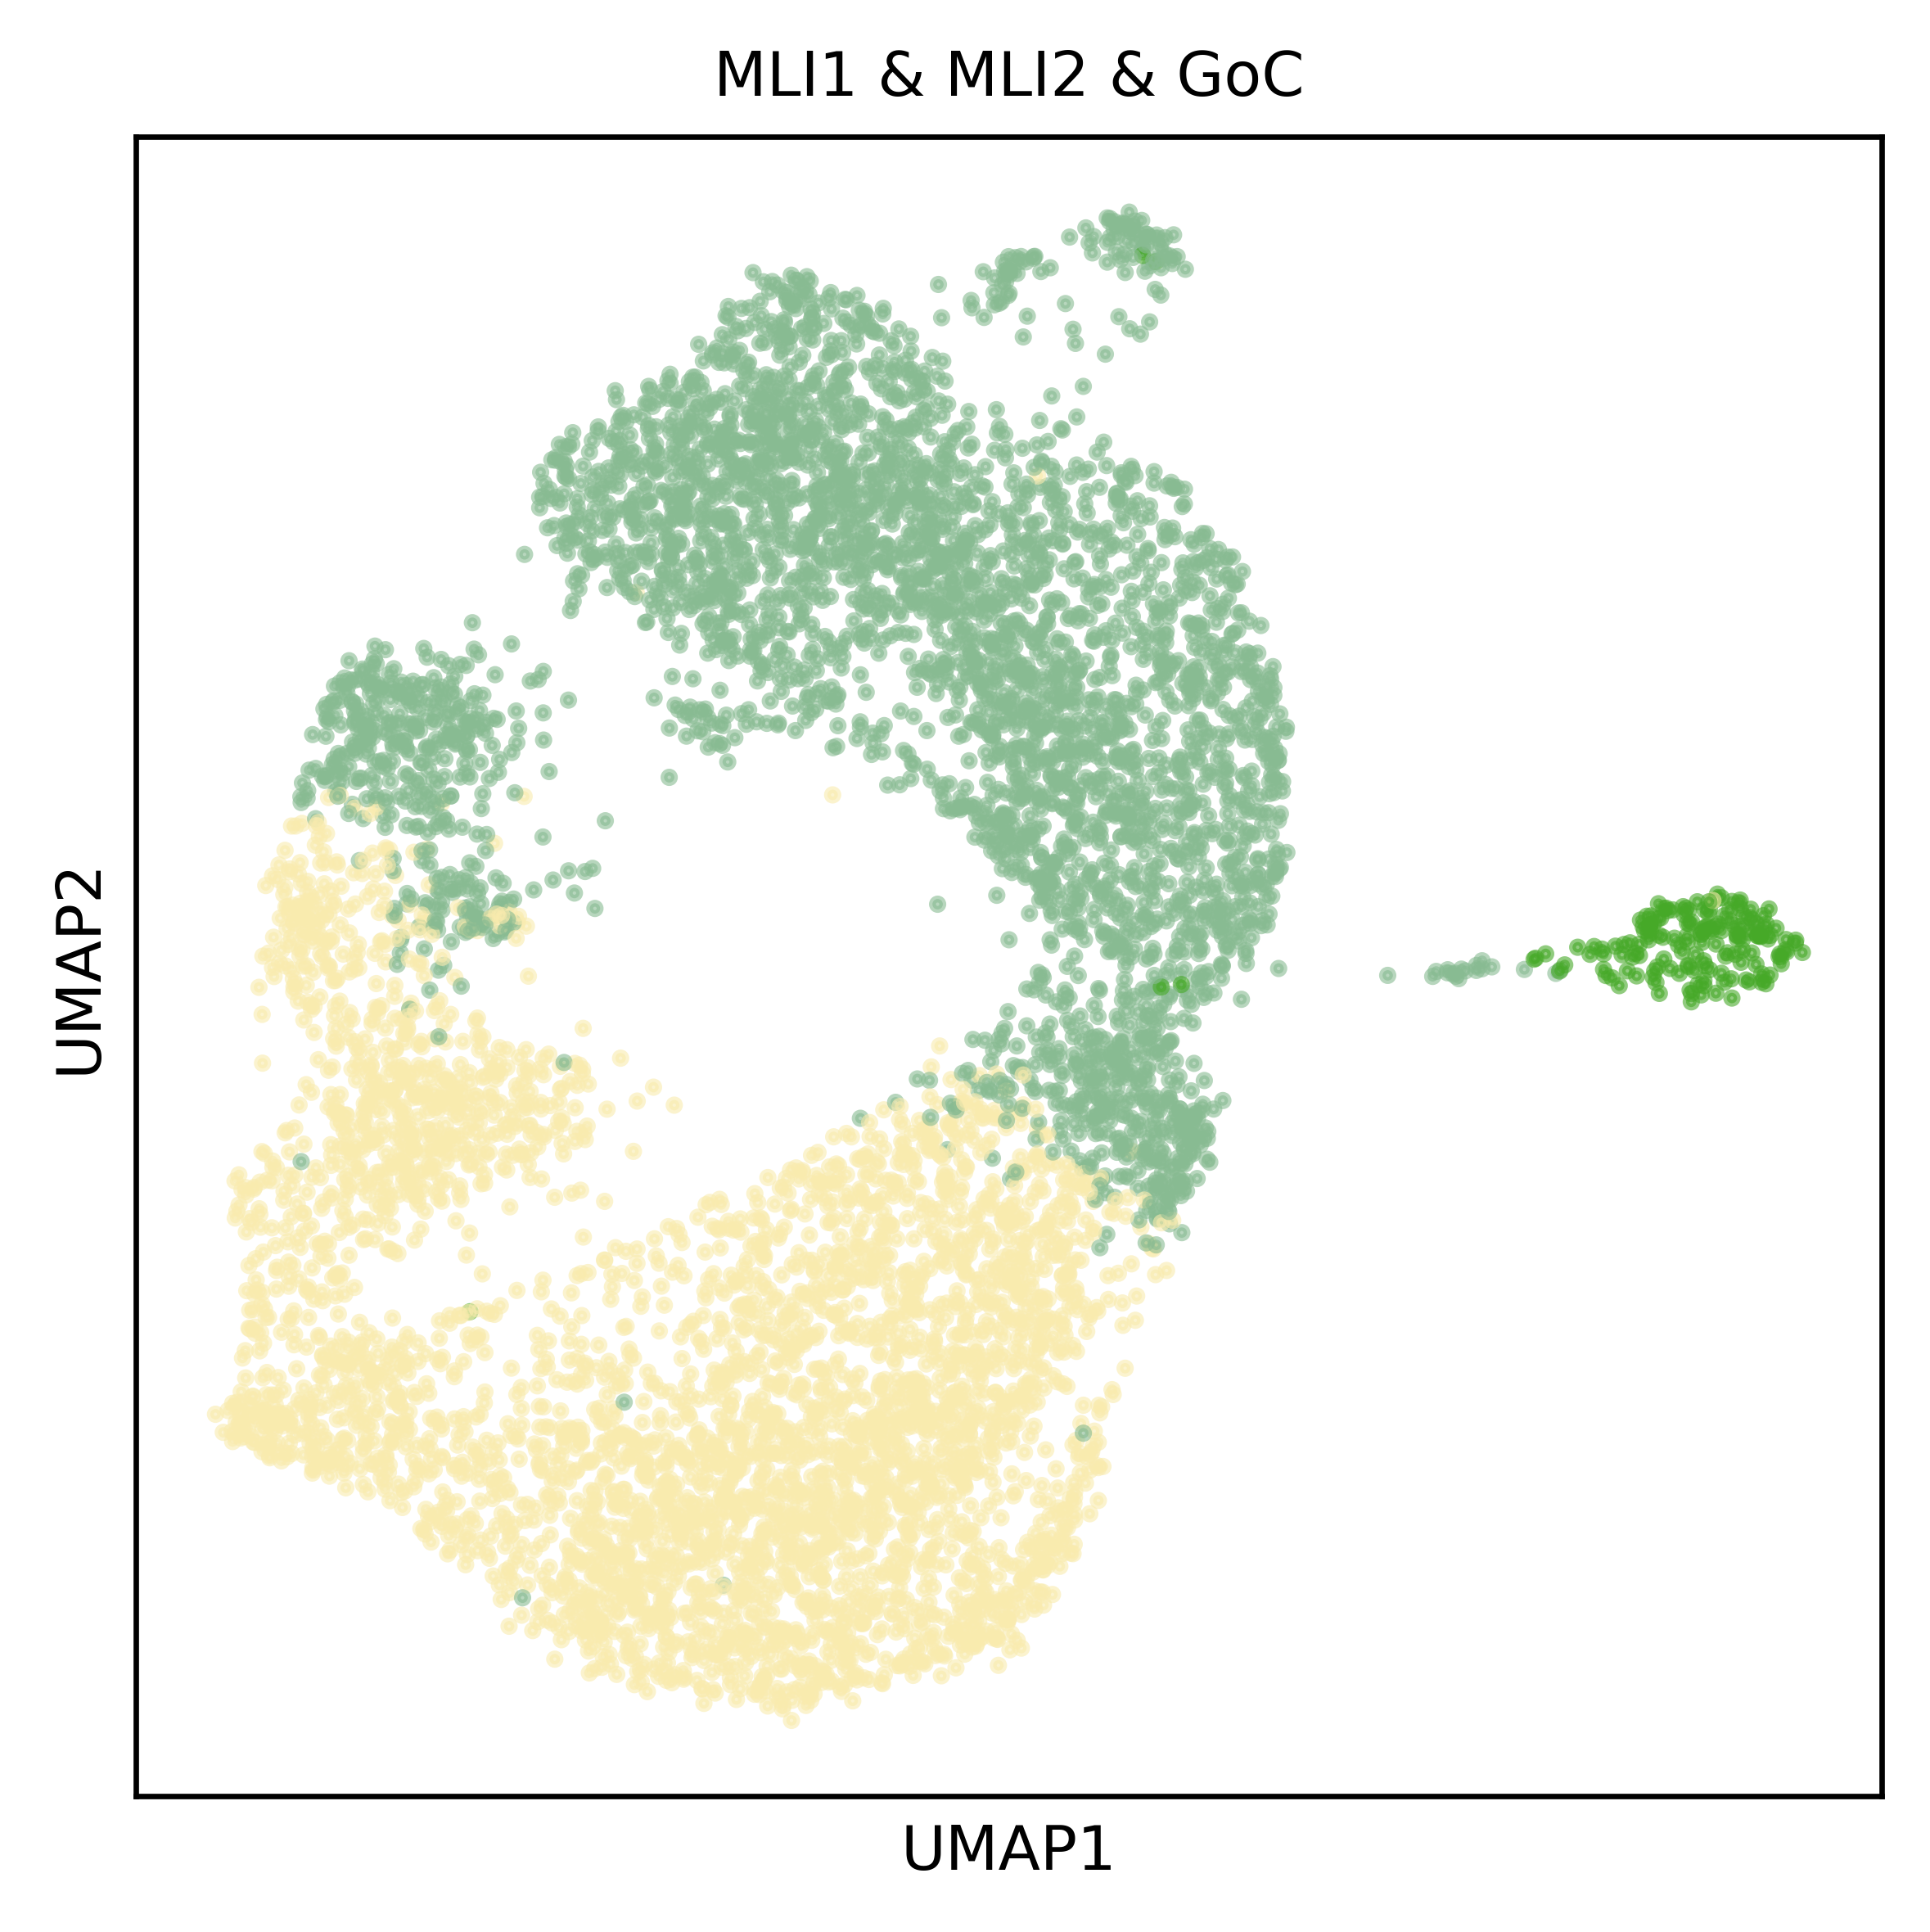

In [10]:
# MLI1 & MLI2 & GoC

total_embeds_ctype=time.time()
if True:
    start = time.time()
    fname=os.path.join(pfp,'embeds_hum_')
    X = hdata[((hdata.obs['sub4']=='MLI1')|
          (hdata.obs['sub4']=='MLI2')|(hdata.obs['sub4']=='GoC')),:]
    sc.tl.pca(X,n_comps=100)
    sc.external.pp.bbknn(X,batch_key='batch')
    sc.tl.umap(X)
    sc.tl.louvain(X,resolution=0.5)
    X.obs['ctype_genotype']=X.obs['genotype'].astype(str)
    X.obs['ctype_genotype'][((X.obs['genotype']=='Ctrl') & (X.obs['sub4']=='MLI1'))]='MLI1 (CTRL)'
    X.obs['ctype_genotype'][((X.obs['genotype']=='Ctrl') & (X.obs['sub4']=='MLI2'))]='MLI2 (CTRL)'
    X.obs['ctype_genotype'][((X.obs['genotype']=='Ctrl') & (X.obs['sub4']=='GoC'))]='GoC (CTRL)'
    X.obs['ctype_genotype'][((X.obs['genotype']=='SCA1') & (X.obs['sub4']=='MLI1'))]='MLI1 (SCA1)'
    X.obs['ctype_genotype'][((X.obs['genotype']=='SCA1') & (X.obs['sub4']=='MLI2'))]='MLI2 (SCA1)'
    X.obs['ctype_genotype'][((X.obs['genotype']=='SCA1') & (X.obs['sub4']=='GoC'))]='GoC (SCA1)'
    cmap = {'MLI1 (CTRL)':'#F9EBAE', 
        'MLI2 (CTRL)':'#88BB92',
        'GoC (CTRL)':'#46A928', 
        'MLI1 (SCA1)':'#F9EBAE', 
        'MLI2 (SCA1)':'#88BB92',
        'GoC (SCA1)':'#46A928'}
    scprep.plot.scatter2d(X.obsm['X_umap'],
                          c=X.obs['ctype_genotype'],
                          cmap=cmap,
                          ticks=None,
                          label_prefix='UMAP',
                          legend=False,
                          alpha=0.6,
                          title='MLI1 & MLI2 & GoC',
                          rasterized=True,
                          filename="230519_umap_MLI1&2&GoC.pdf",
                          dpi=300)

#     print('\n{} ({}/{}) subset done in {:.2f}-s\n'.format(ctype,i+1,len(ctypes),time.time() - start))
# print('\n{} clusters in in {:.2f}-min'.format(len(ctypes),(time.time() - total_embeds_ctype)/60))



... storing 'batch' as categorical
... storing 'genotype' as categorical
... storing 'sub1' as categorical
... storing 'ctype_genotype' as categorical


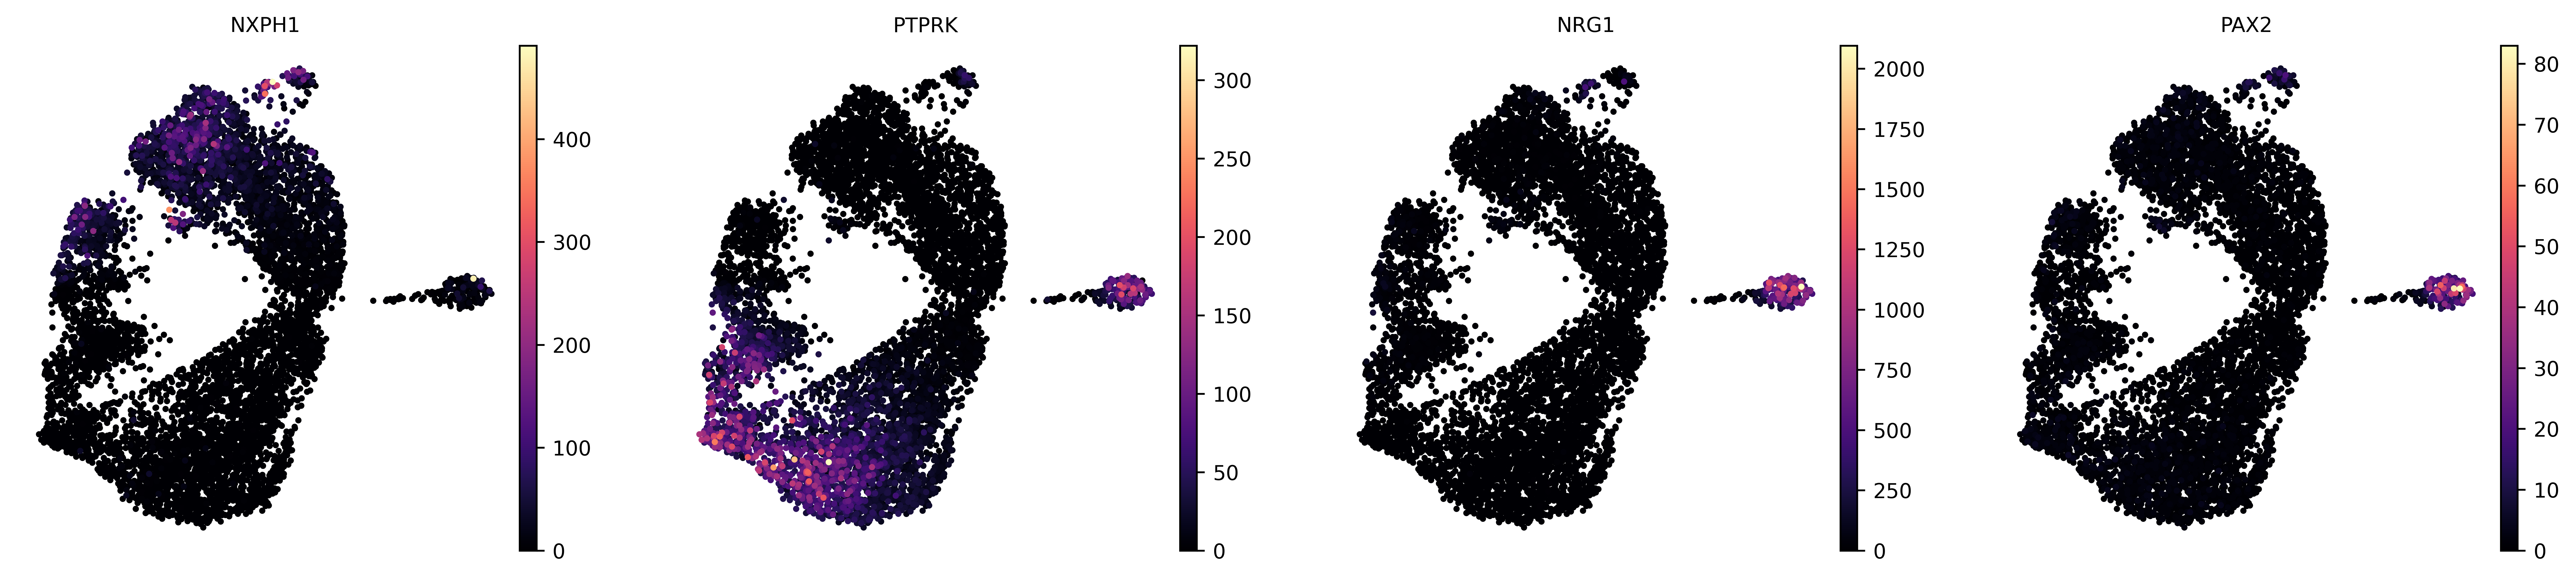

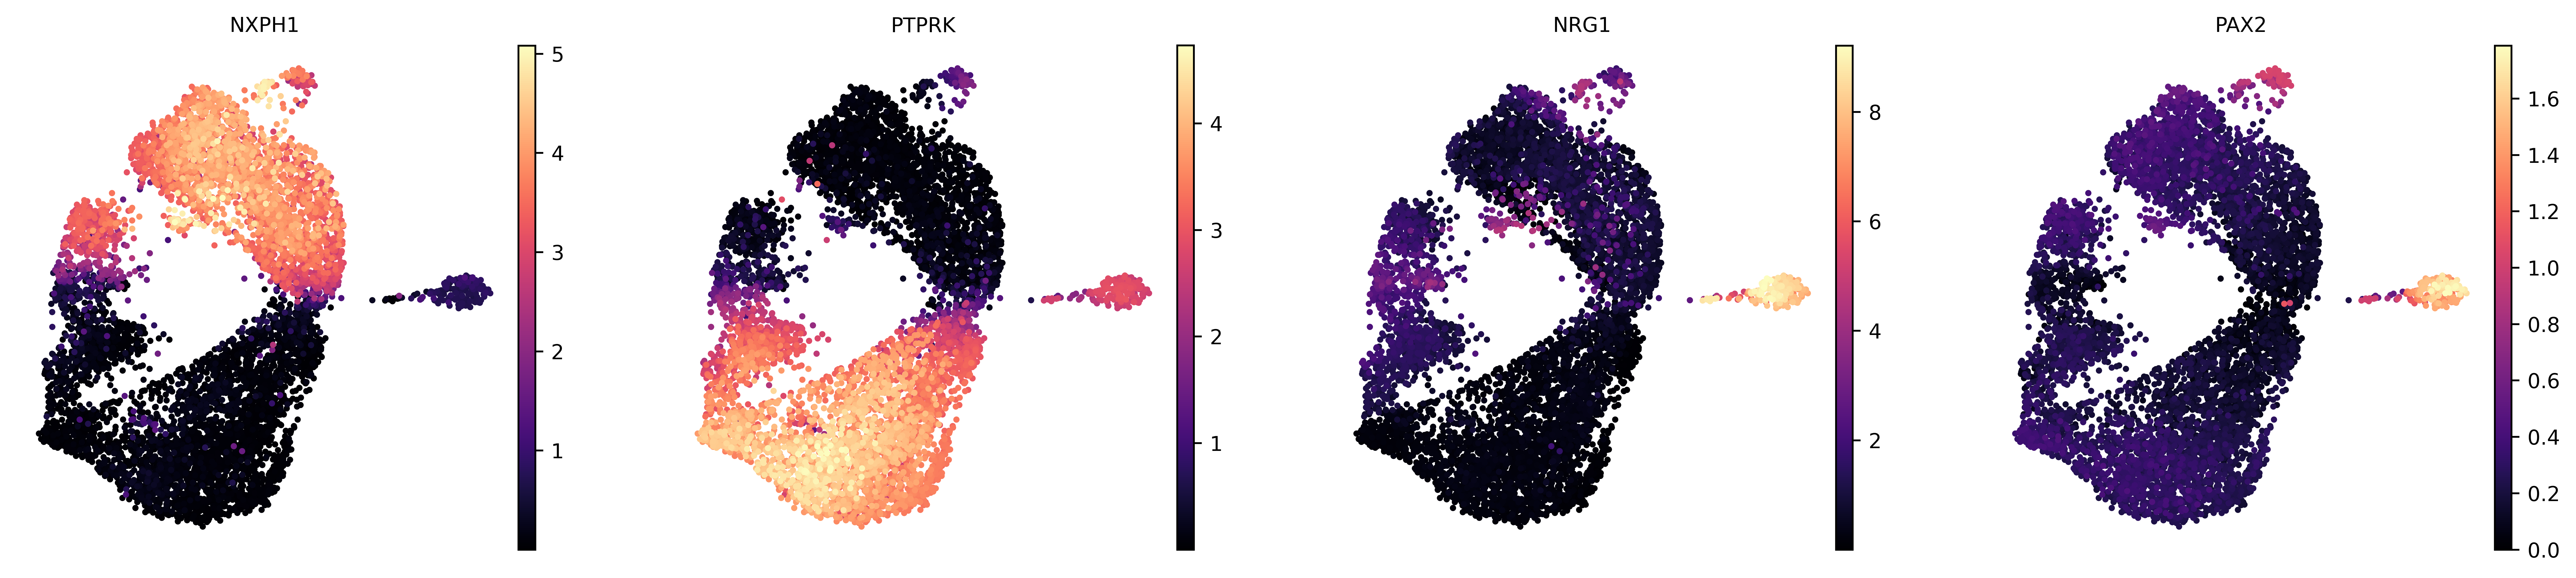

In [11]:
genes = ['NXPH1', 'PTPRK', 'NRG1','PAX2']
sc.pl.umap(X, color =genes, size = 30, cmap = 'magma', save = '230519_umap_MLI_genes_before_magic.pdf')
sc.pl.umap(X, color =genes, size = 30, cmap = 'magma',  layer = 'imputed', save = '230519_umap_MLI_genes_after_magic.pdf')

... storing 'batch' as categorical
... storing 'genotype' as categorical
... storing 'louvain' as categorical
... storing 'sub1' as categorical


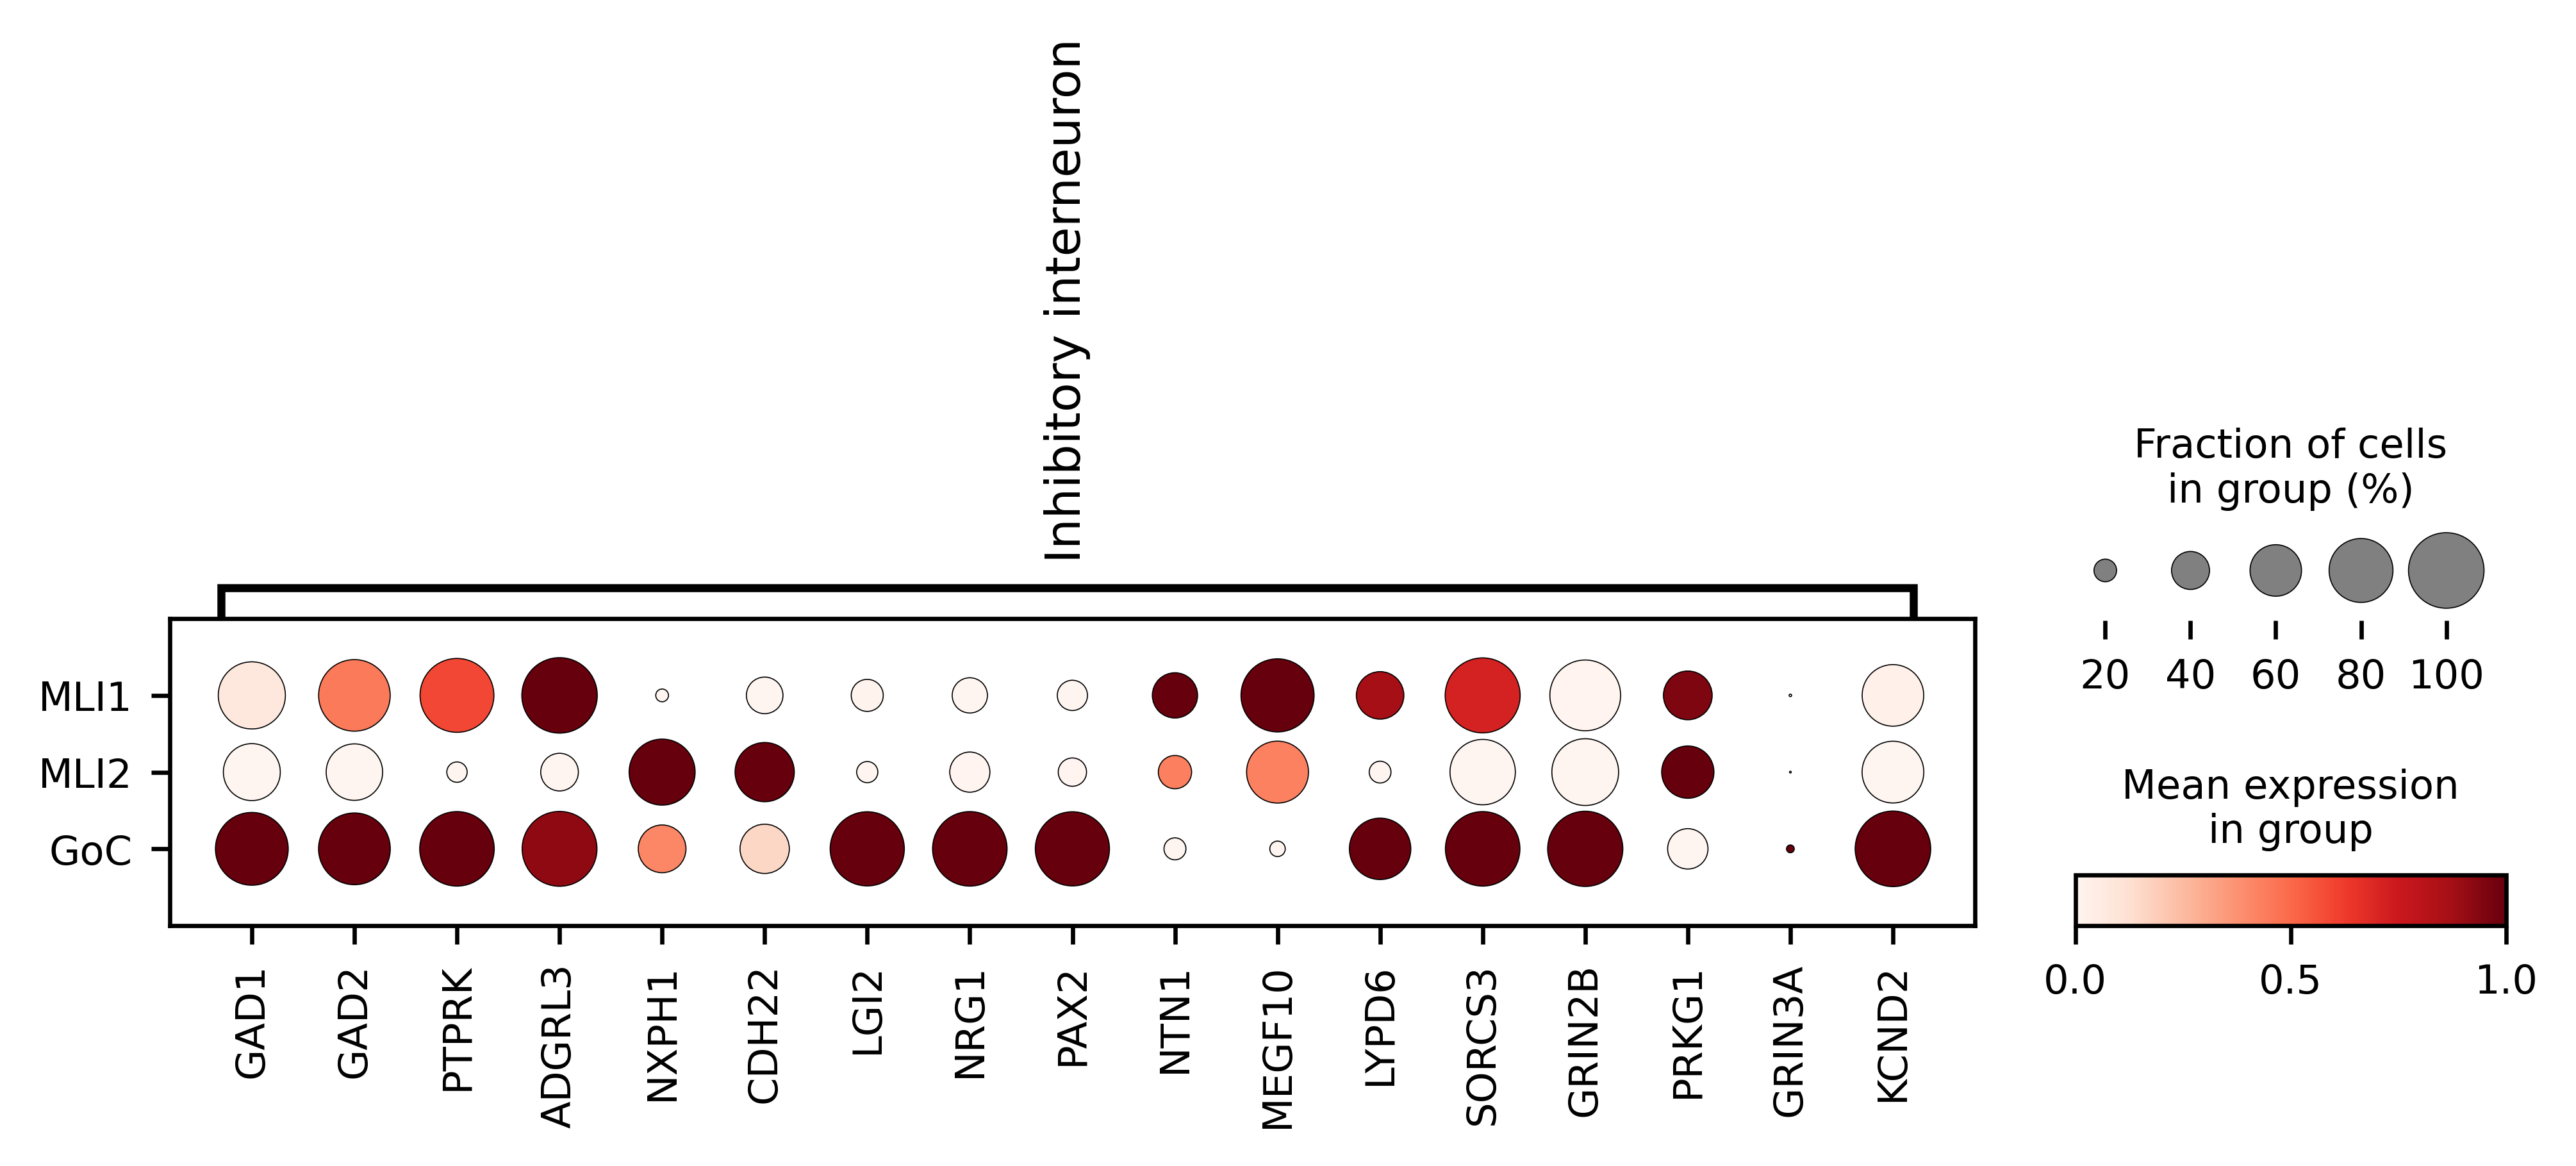

In [12]:
## markers for MLI1, MLI2, GoC

inmarkers = {
    'Inhibitory interneuron':['GAD1','GAD2','PTPRK','ADGRL3','NXPH1','CDH22', 'LGI2','NRG1','PAX2','NTN1','MEGF10', 'LYPD6', 'SORCS3','GRIN2B','PRKG1', 'GRIN3A', 'KCND2']}

obs = 'sub4'
# tdata = hdata[(hdata.obs[obs]=="GoC")|
#               (hdata.obs[obs]=="MLI1")|(hdata.obs[obs]=="MLI2")           
#               , :]

sc.pl.dotplot(hdata, inmarkers, groupby=obs, standard_scale='var', use_raw=True, save = '230519_IN_dot.pdf')